In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
import multiprocess as mp
import fitsio,glob,corner,emcee,os

In [2]:
lcparams_file='jla_likelihood_v6/data/jla_lcparams.txt'

In [3]:
z=np.genfromtxt(lcparams_file,usecols=1)
data=np.genfromtxt(lcparams_file,usecols=np.arange(4,12,2),unpack=True)

In [4]:
mb,X1,C,thirdvar=data
eta=np.array([mb,X1,C]).T.reshape(3*len(mb),)

In [5]:
def get_MB(thirdvar,MB,dMB):
    if thirdvar<10:
        return MB
    return MB+dMB
MB_vec=np.vectorize(get_MB)

def kronecker_delta(i,j):
    if i==j: return 1
    return 0

A0 = np.zeros((len(thirdvar),3*len(thirdvar)))
A1 = np.zeros((len(thirdvar),3*len(thirdvar)))
A2 = np.zeros((len(thirdvar),3*len(thirdvar)))
for i in range(len(thirdvar)):
    for j in range(3*len(thirdvar)):
        A0[i,j]=kronecker_delta(3*i,j)
        A1[i,j]=kronecker_delta(3*i,j-1)
        A2[i,j]=kronecker_delta(3*i,j-2)

In [6]:
C_eta=np.sum([fitsio.read(cfile) for cfile in glob.glob('jla_likelihood_v6/covmat/C_*.fits')],axis=0)
sigma_coh,sigma_lens,z_error=np.loadtxt('jla_likelihood_v6/covmat/sigma_mu.txt',unpack=True)
sigma_z = (5*150/3e5)/(np.log(10)*z_error)
diag_errors = np.diag(sigma_z**2+sigma_coh**2+sigma_lens**2)

In [7]:
def loglike(params):
    Om,alpha,beta,Mb,dMb = params
    A = A0+alpha*A1-beta*A2
    MB = MB_vec(thirdvar,Mb,dMb)
    mu_obs=mb-(MB-alpha*X1+beta*C)
    covmat = np.matmul(np.matmul(A,C_eta),A.T)+diag_errors
    inv_covmat = np.linalg.inv(covmat)
    d_L = FlatLambdaCDM(H0=70, Om0=Om, Tcmb0=2.725).luminosity_distance(z)  
    mu_mod = 5*np.log10(d_L.value/10e-6)
    diff = mu_obs-mu_mod
    return -0.5*np.matmul(diff.T,np.matmul(inv_covmat,diff))

def priors(params):
    p=True
    for i,param in enumerate(params):
        p &= plist[2*i]<param<plist[2*i+1]
    if p==True:
        return 0.0
    return -np.inf

def logpost(params):
    prior = priors(params)
    if not np.isfinite(prior):
        return -np.inf
    return prior + loglike(params)

In [8]:
ndim = 5
nwalkers = ndim*30
steps=500

In [9]:
inivals=[0.5,0.1,3,-10,0]
plist=[0,1,-1,1,0,20,-30,0,-1,1]
pos = inivals + 1e-1 * np.random.randn(nwalkers, ndim)

In [10]:
ncpu = mp.cpu_count()
print("{0} CPUs".format(ncpu))

4 CPUs


In [11]:
filename = "emcee.h5"
if os.path.exists(filename):
    sampler = emcee.backends.HDFBackend(filename)
    print('Emcee file exists; skipping')
else:
    with mp.Pool(4) as pool:
        backend = emcee.backends.HDFBackend(filename)
        sampler = emcee.EnsembleSampler(nwalkers, ndim,logpost,pool=pool,backend=backend)
        pos,prob,state=sampler.run_mcmc(pos, steps, progress=True)

100%|██████████| 500/500 [5:51:18<00:00, 42.16s/it]  


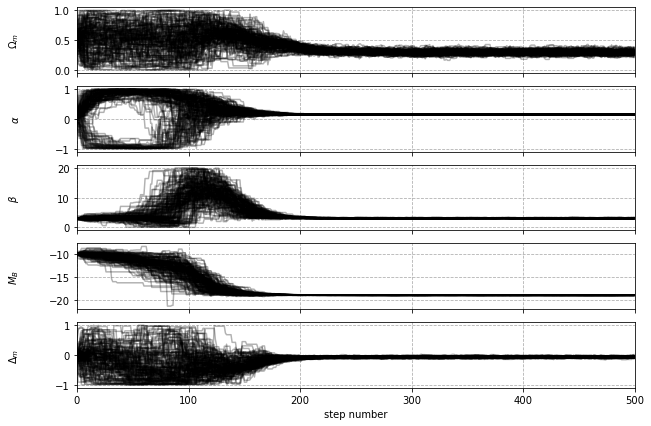

In [12]:
chain = sampler.get_chain()
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
labels = [r'$\Omega_m$',r'$\alpha$',r'$\beta$',r'$M_B$',r'$\Delta_m$']
for i in range(ndim):
    ax = axes[i]
    ax.plot(chain[:,:, i],'k', alpha=0.3)
    ax.set_xlim(0, len(chain))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.grid(linestyle='--')

axes[-1].set_xlabel("step number");

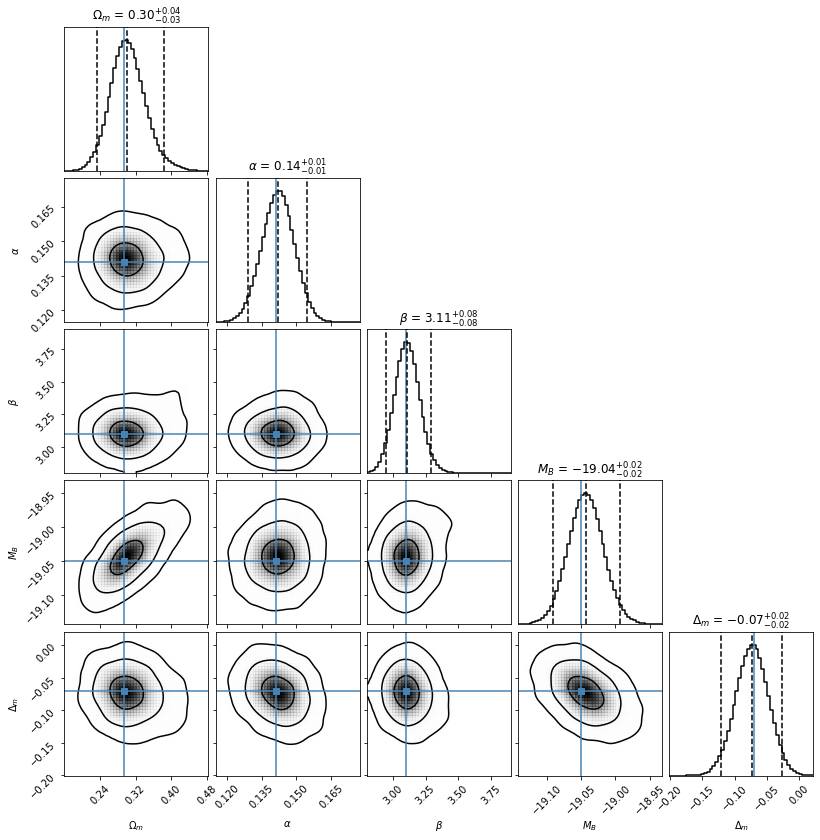

In [13]:
fig = corner.corner(sampler.get_chain(discard=200, flat=True),labels=labels,bins=50,
                    plot_datapoints=False,smooth=2.,smooth1d=2.,
                    levels=(1.-np.exp(-0.5),1.-np.exp(-2.),1.-np.exp(-4.5)),quantiles=[.025,0.5,0.975],
                    show_titles=True,truths=[0.295,0.141,3.101,-19.05, -0.070]);

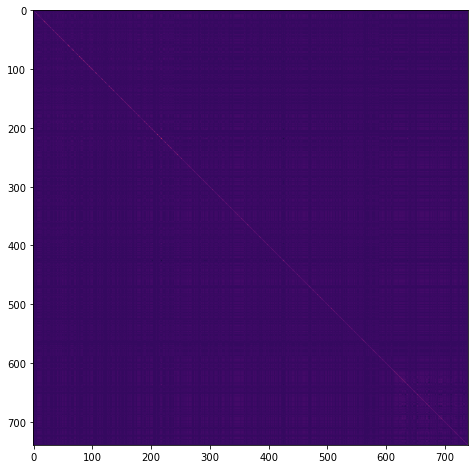

In [31]:
A = A0+args[1]*A1-args[2]*A2
covmat = np.matmul(np.matmul(A,C_eta),A.T)+diag_errors
plt.figure(figsize=(8,8))
plt.imshow(covmat,cmap='inferno')

In [36]:
errors=np.sqrt(np.diagonal(covmat))

In [24]:
args=np.median(sampler.get_chain(discard=200, flat=True),axis=0)
truevals=np.array([0.295,0.141,3.101,-19.05, -0.070])
args

array([  0.30114143,   0.14216695,   3.10915649, -19.04333436,
        -0.07270183])

In [22]:
100*abs((args-truevals)/truevals)

array([2.08183993, 0.82762555, 0.26302763, 0.03499026, 3.85975461])

In [16]:
-2*loglike(args)/(740-5)

0.9292175557073309

<ipython-input-45-babe81380ea7>:3: RuntimeWarning: divide by zero encountered in log10
  mu_mod = 5*np.log10(d_L.value/10e-6)


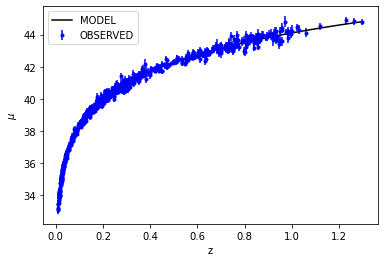

In [45]:
z_mod=np.linspace(0,1.3,100)
d_L = FlatLambdaCDM(H0=70, Om0=args[0], Tcmb0=2.725).luminosity_distance(z_mod)  
mu_mod = 5*np.log10(d_L.value/10e-6)
MB=MB_vec(thirdvar,args[3],args[4])
mu_obs= mb-(MB-args[1]*X1+args[2]*C)

plt.errorbar(z,mu_obs,errors,marker='.',ls='none',color='b',label='OBSERVED')
plt.plot(z_mod,mu_mod,'k-',label='MODEL')
plt.xlabel('z')
plt.ylabel(r'$\mu$')
plt.legend();

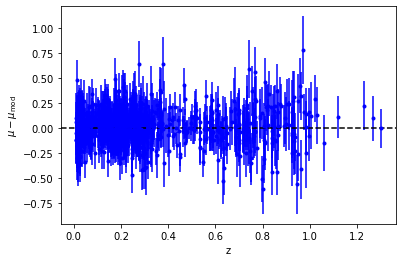

In [44]:
d_L = FlatLambdaCDM(H0=70, Om0=args[0], Tcmb0=2.725).luminosity_distance(z)  
mu_mod = 5*np.log10(d_L.value/10e-6)
plt.axhline(0,color='k',ls='--')
plt.errorbar(z,mu_obs-mu_mod,errors, marker='.',ls='none',color='b')
plt.xlabel('z')
plt.ylabel(r'$\mu-\mu_{\rm{mod}}$');